In [6]:
import env

from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

import utilities as utils

In [212]:
def generate_column_counts_df(df, target_col):
    """
    Generates a dataframe containing the counts of a target variable within the dataframe.
    
    Parameters
    ----------
    df : DataFrame
        The dataframe containing the target variable
    target_var : string
        The key name for the target variable column

    Returns
    -------
    DataFrame
        Dataframe containing the target variable and the counts of the target occurring within the dataframe.
    """
    
    return df[target_col].value_counts(dropna=False).reset_index().\
                rename(columns={'index': target_col, target_col : target_col + '_count'})

In [214]:
def generate_column_probability_df(df, target_col):
    """
    Generates a dataframe containing the probability of a target variable within the dataframe.
    
    Parameters
    ----------
    df : DataFrame
        The dataframe containing the target variable
    target_var : string
        The key name for the target variable column

    Returns
    -------
    DataFrame
        Dataframe containing the target variable and the probabilities of the target occurring within the dataframe.
    """
        
    return (df[target_col].value_counts(dropna=False)/df[target_col].count()).reset_index().\
                rename(columns={'index': target_col, target_col : target_col + '_proba'})

In [215]:
def generate_counts_and_probability_df(df, target_var):
    """
    Generates a dataframe containing the counts and probabilities of a target variable within the dataframe.
    
    Parameters
    ----------
    df : DataFrame
        The dataframe containing the target variable
    target_var : string
        The key name for the target variable column

    Returns
    -------
    DataFrame
        Dataframe containing the target variable, the counts, and probabilities of the target occurring within the dataframe.
    """

    counts_df = generate_column_counts_df(df, target_var)
    probability_df = generate_column_probability_df(df, target_var)
    
    return counts_df.merge(probability_df)

In [210]:
def generate_conditional_probability_df(df, target_var, conditional_var):
    """
    Generates a dataframe containing the conditional probability of a target variable occurring given a conditional variable's presence.
    
    Parameters
    ----------
    df : DataFrame
        The dataframe containing the target and conditional variables
    target_var : string
        The key name for the target variable column
    conditional_var : string
        The key name for the conditional variable column

    Returns
    -------
    DataFrame
        Dataframe containing the target variable, the conditional variable, and the probability of the combination occurring within the dataframe.
    """
    
    probabilities = df.groupby([conditional_var]).size().div(len(df))
    
    conditional_proba_df = pd.DataFrame(df.groupby([conditional_var, target_var]).size().div(len(df)).\
                              div(probabilities, axis=0, level=conditional_var).\
                              reset_index().\
                              rename(columns={0 : 'proba_' + target_var + '_given_' + conditional_var}))
    
    return conditional_proba_df

In [216]:
def visualize_target_counts(df, target_var, target_counts, fig_size=(12, 8)):
    """
    Creates a barplot of the different values for the target variable and the count for each.
    
    Parameters
    ----------
    df : DataFrame
        The dataframe containing the target variable
    target_var : string
        The key name for the target variable column
    target_counts : string
        The key name for the counts of the target variable column
    fig_size : tuple of (int, int)
        The dimensions for the barplot (default=(12,8))

    Returns
    -------
    None
    """
    
    plt.figure(figsize=fig_size)
    
    splot = sns.barplot(data=df, x = target_var, y = target_counts, ci = None)
    
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', xytext = (0, 10), 
                       textcoords = 'offset points'
                       )
    plt.xticks(rotation='vertical')
    plt.show()

# Discrete Data + Probability
## Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

### Acquire

In [83]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [84]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


### Prepare

In [86]:
# begin cleaning up the timestamp by removing the brackets and extraneous tail
df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)

In [87]:
# replace the first colon in the timestamp before year 
# to accomodate for pandas datetime
df.timestamp = pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))

In [88]:
df.timestamp.head()

0   2019-04-16 19:34:42
1   2019-04-16 19:34:42
2   2019-04-16 19:34:44
3   2019-04-16 19:34:46
4   2019-04-16 19:34:48
Name: timestamp, dtype: datetime64[ns]

In [89]:
df = utils.set_index_to_datetime(df, 'timestamp')

In [90]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [91]:
df.request_method.value_counts()

"GET /api/v1/sales?page=2 HTTP/1.1"                       709
"GET /api/v1/items HTTP/1.1"                              464
"GET /api/v1/items?page=2 HTTP/1.1"                       291
"GET /api/v1/items?page=3 HTTP/1.1"                       219
"GET /api/v1/stores HTTP/1.1"                             162
                                                         ... 
"GET /api/V1/HiZach! HTTP/1.1"                              1
"GET /api/v1/items?page=99999999999999999998 HTTP/1.1"      1
"GET /api/v1 HTTP/1.1"                                      1
"GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1"                    1
"GET /api/v1/helloclass! HTTP/1.1"                          1
Name: request_method, Length: 220, dtype: int64

In [92]:
df[df.request_method.str.find("HTTP/1.1") > -1]

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""
...,...,...,...,...,...,...
2019-04-17 12:55:14,97.105.19.58,"""GET /api/v1/sales?page=71 HTTP/1.1""",200,510166,NaN,"""python-requests/2.21.0"""
2019-04-17 19:36:41,95.31.16.121,GET /api/v1/sales?page=79/HTTP/1.1,301,1005,NaN,python-requests/2.21.0
2019-04-18 19:42:41,97.105.15.120,GET /api/v1/sales?page=79/HTTP/1.1,301,2560,NaN,python-requests/2.21.0


Since all rows have "HTTP/1.1" at the end, I will remove it since it does not add any value. Also, there are some requests that have quotes around them, so they will be removed. Strip any leading/trailing whitespace.

In [93]:
df.request_method = df.request_method.str.replace("HTTP/1.1", "").str.replace('"', '').str.strip()

In [94]:
requests_with_parameters = df[df.request_method.str.find("?") > -1]

In [95]:
requests_with_parameters.sample(50)

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:52:54,97.105.19.58,GET /api/v1/sales?page=117,200,511979,NaN,"""python-requests/2.21.0"""
2019-04-16 20:03:15,97.105.19.58,GET /api/v1/sales?page=146,200,511562,NaN,"""python-requests/2.20.1"""
2019-04-16 20:00:54,97.105.19.58,GET /api/v1/sales?page=56,200,510120,NaN,"""python-requests/2.21.0"""
2019-04-17 03:39:56,72.181.113.170,GET /api/v1/sales?page=54,200,511118,NaN,"""python-requests/2.21.0"""
2019-04-16 21:51:35,97.105.19.58,GET /api/v1/sales?page=34,200,511390,NaN,"""python-requests/2.21.0"""
2019-04-17 05:19:52,173.173.113.51,GET /api/v1/sales?page=176,200,511624,NaN,"""python-requests/2.21.0"""
2019-04-16 21:41:00,97.105.19.58,GET /api/v1/sales?page=1,200,493905,NaN,"""python-requests/2.21.0"""
2019-04-16 21:53:16,97.105.19.58,GET /api/v1/sales?page=83,200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 21:08:54,97.105.19.58,GET /api/v1/sales?page=140,200,510152,NaN,"""python-requests/2.21.0"""


I am going to assume any request with a "?" specifying parameters in the url, so I will remove the question mark and everything after to only have the root URL.

In [96]:
df.request_method = df.request_method.apply(lambda x : x.split("?", 1)[0])

In [97]:
df.sample(14)

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 20:19:23,97.105.19.58,GET /api/v1/sales,200,510445,NaN,"""python-requests/2.21.0"""
2019-04-16 21:25:24,97.105.19.58,GET /,200,42,NaN,"""python-requests/2.21.0"""
2019-04-16 20:48:31,97.105.19.58,GET /api/v1/sales,200,509795,NaN,"""python-requests/2.21.0"""
2019-04-16 22:08:01,97.105.19.58,GET /api/v1/sales,200,500461,NaN,"""python-requests/2.21.0"""
2019-04-16 20:02:09,97.105.19.58,GET /api/v1/items,200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 20:42:34,97.105.19.58,GET /api/v1/sales,200,510753,NaN,"""python-requests/2.21.0"""
2019-04-16 22:37:45,97.105.19.58,GET /api/v1/sales,200,510862,NaN,"""python-requests/2.21.0"""
2019-04-17 04:59:33,173.173.113.51,GET /api/v1/items,200,1787,NaN,"""python-requests/2.21.0"""
2019-04-17 04:42:17,173.173.113.51,GET /api/v1/sales,200,506822,NaN,"""python-requests/2.21.0"""


### Anomalies within the data

In [98]:
def generate_column_counts_df(df, column):
    return df[column].value_counts(dropna=False).reset_index().\
                rename(columns={'index': column, column : column + '_count'})

In [99]:
# get the counts of requests in the dataset
request_df = generate_column_counts_df(df, 'request_method')
request_df

,request_method,request_method_count
0,GET /api/v1/sales,12406
1,GET /api/v1/items,1065
2,GET /api/v1/stores,229
3,GET /,107
4,GET /documentation,100
5,GET /favicon.ico,26
6,GET /api/v1//api/v1/items,11
7,GET /api/v1/items/api/v1/items,7
8,GET /api/v1/items/next_page,5
9,GET /api/v1/,4


In [100]:
def generate_column_probability_df(df, column):
    return (df[column].value_counts(dropna=False)/df[column].count()).reset_index().\
                rename(columns={'index': column, column : column + '_proba'})

In [101]:
# get the probability of that request in the dataset
request_df2 = generate_column_probability_df(df, 'request_method')
# merge/join these together
request_df = request_df.merge(request_df2)
request_df

,request_method,request_method_count,request_method_proba
0,GET /api/v1/sales,12406,0.887538
1,GET /api/v1/items,1065,0.076191
2,GET /api/v1/stores,229,0.016383
3,GET /,107,0.007655
4,GET /documentation,100,0.007154
5,GET /favicon.ico,26,0.001860
6,GET /api/v1//api/v1/items,11,0.000787
7,GET /api/v1/items/api/v1/items,7,0.000501
8,GET /api/v1/items/next_page,5,0.000358
9,GET /api/v1/,4,0.000286


In [102]:
# alter the request df to only see those where rate < 1% 
request_df[request_df.request_method_proba < 0.01]

,request_method,request_method_count,request_method_proba
3,GET /,107,0.007655
4,GET /documentation,100,0.007154
5,GET /favicon.ico,26,0.001860
6,GET /api/v1//api/v1/items,11,0.000787
7,GET /api/v1/items/api/v1/items,7,0.000501
8,GET /api/v1/items/next_page,5,0.000358
9,GET /api/v1/,4,0.000286
10,GET /api/v1/itemsitems,3,0.000215
11,GET /api/v1/sales/,3,0.000215
12,GET /api/v1/store,3,0.000215


21
                         request_method  request_method_count  \
11                   GET /api/v1/sales/                     3   
12                    GET /api/v1/store                     3   
13                     GET /api/v1items                     2   
14                          GET /api/v1                     1   
15                   GET /api/v1/items/                     1   
16  GET /api/v1//api/v1/items/next_page                     1   
17        GET /api/v1/I_DIDNT_DO_IT!!!!                     1   
18             GET /api/v1/items&page=0                     1   
19              GET /api/v1/helloclass!                     1   
20                  GET /api/V1/HiZach!                     1   

    request_method_proba  
11              0.000215  
12              0.000215  
13              0.000143  
14              0.000072  
15              0.000072  
16              0.000072  
17              0.000072  
18              0.000072  
19              0.000072  
20         

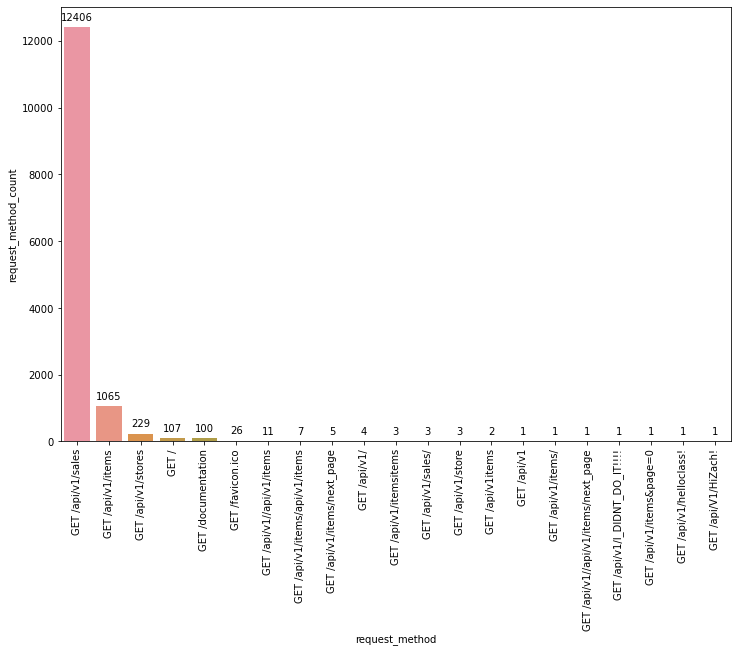

In [103]:
print(len(request_df))

print(request_df.tail(10))

plt.figure(figsize=(12, 8))
splot = sns.barplot(data=request_df, x = 'request_method', y = 'request_method_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
plt.xticks(rotation='vertical')
plt.show()

### Detecting anomalies from new data with a baseline

In [104]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales,200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items,200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales,200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales,200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales,200,511963,NaN,"""python-requests/2.21.0"""


In [105]:
df.tail()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-17 12:55:14,97.105.19.58,GET /api/v1/sales,200,510166,NaN,"""python-requests/2.21.0"""
2019-04-17 19:36:41,95.31.16.121,GET /api/v1/sales,301,1005,NaN,python-requests/2.21.0
2019-04-18 19:42:41,97.105.15.120,GET /api/v1/sales,301,2560,NaN,python-requests/2.21.0
2019-04-19 19:42:41,97.105.19.58,GET /api/v1/sales,200,2056327,NaN,python-requests/2.21.0
2019-04-21 10:02:41,95.31.18.119,GET /api/v1/items/,200,1153005,NaN,python-requests/2.21.0


My baseline will be everything from 4/16 and 4/17.

In [106]:
train = df.loc['2019-04-16 19:34:42' : '2019-04-17 19:36:41']
train

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales,200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items,200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales,200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales,200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales,200,511963,NaN,"""python-requests/2.21.0"""
...,...,...,...,...,...,...
2019-04-17 12:55:12,97.105.19.58,GET /api/v1/sales,200,511201,NaN,"""python-requests/2.21.0"""
2019-04-17 12:55:13,97.105.19.58,GET /api/v1/sales,200,511781,NaN,"""python-requests/2.21.0"""
2019-04-17 12:55:13,97.105.19.58,GET /api/v1/sales,200,510136,NaN,"""python-requests/2.21.0"""


In [107]:
request_df = generate_column_probability_df(train, 'request_method')
request_df

,request_method,request_method_proba
0,GET /api/v1/sales,0.887585
1,GET /api/v1/items,0.076208
2,GET /api/v1/stores,0.016386
3,GET /,0.007657
4,GET /documentation,0.007156
5,GET /favicon.ico,0.001860
6,GET /api/v1//api/v1/items,0.000787
7,GET /api/v1/items/api/v1/items,0.000501
8,GET /api/v1/items/next_page,0.000358
9,GET /api/v1/,0.000286


In [108]:
df = df.reset_index().merge(request_df, on=['request_method'], how='left').fillna(value=0).set_index('timestamp')

In [109]:
# value counts?
df[df['request_method_proba'] == 0]

,ip,request_method,status,size,destination,request_agent,request_method_proba
timestamp,,,,,,,
2019-04-21 10:02:41,95.31.18.119,GET /api/v1/items/,200,1153005,0,python-requests/2.21.0,0.0


### Conditional Probabilities

In [131]:
ip_probs = train.groupby(['ip', 'request_method']).size().div(len(train))
ip_probs

ip              request_method    
173.173.113.51  GET /                 0.000072
                GET /api/v1/items     0.013453
                GET /api/v1/sales     0.058318
                GET /api/v1/stores    0.003864
                GET /documentation    0.000072
                                        ...   
97.105.19.58    GET /api/v1/store     0.000215
                GET /api/v1/stores    0.011377
                GET /api/v1items      0.000072
                GET /documentation    0.006655
                GET /favicon.ico      0.001002
Length: 62, dtype: float64

In [132]:
request_given_ip = pd.DataFrame(train.groupby(['ip', 'request_method']).size().div(len(train)).\
                              div(ip_probs,
                                 axis=0,
                                 level='ip').\
                              reset_index().\
                              rename(columns={0: 'proba_request_given_ip'})
                              )
request_given_ip

,ip,request_method,proba_request_given_ip
0,173.173.113.51,GET /,1.0
1,173.173.113.51,GET /api/v1/items,1.0
2,173.173.113.51,GET /api/v1/sales,1.0
3,173.173.113.51,GET /api/v1/stores,1.0
4,173.173.113.51,GET /documentation,1.0
...,...,...,...
57,97.105.19.58,GET /api/v1/store,1.0
58,97.105.19.58,GET /api/v1/stores,1.0
59,97.105.19.58,GET /api/v1items,1.0
60,97.105.19.58,GET /documentation,1.0


In [133]:
ip_request_count = pd.DataFrame(train.groupby(['ip', 'request_method'])['status'].\
                              count().reset_index().\
                              rename(columns={'status': 'ip_request_count'}))


ip_request = request_given_ip.merge(ip_request_count)
ip_request

,ip,request_method,proba_request_given_ip,ip_request_count
0,173.173.113.51,GET /,1.0,1
1,173.173.113.51,GET /api/v1/items,1.0,188
2,173.173.113.51,GET /api/v1/sales,1.0,815
3,173.173.113.51,GET /api/v1/stores,1.0,54
4,173.173.113.51,GET /documentation,1.0,1
...,...,...,...,...
57,97.105.19.58,GET /api/v1/store,1.0,3
58,97.105.19.58,GET /api/v1/stores,1.0,159
59,97.105.19.58,GET /api/v1items,1.0,1
60,97.105.19.58,GET /documentation,1.0,93


In [134]:
df = df.reset_index().merge(ip_request, on=['ip', 'request_method'], how='left').fillna(value=0).set_index('timestamp')

In [135]:
df.head()

,ip,request_method,status,size,destination,request_agent,request_method_proba,proba_request_given_ip,ip_request_count
timestamp,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales,200,512495,0,"""python-requests/2.21.0""",0.887585,1.0,10885.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items,200,3561,0,"""python-requests/2.21.0""",0.076208,1.0,714.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales,200,510103,0,"""python-requests/2.21.0""",0.887585,1.0,10885.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales,200,510003,0,"""python-requests/2.21.0""",0.887585,1.0,10885.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales,200,511963,0,"""python-requests/2.21.0""",0.887585,1.0,10885.0


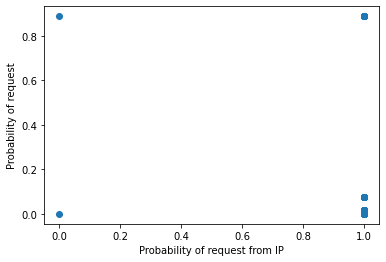

In [138]:
# scatter plot
plt.scatter(df.proba_request_given_ip, df.request_method_proba)
plt.xlabel("Probability of request from IP")
plt.ylabel("Probability of request")
plt.show()

Focus on low probability of request overall with a high probability of request from certain IP.

In [145]:
uncommon_requests_from_the_same_ips = df[(df.proba_request_given_ip > .9) & (df.request_method_proba < .01)]

In [146]:
uncommon_requests_from_the_same_ips.ip.value_counts()

97.105.19.58      240
72.181.105.81      13
68.201.219.223      8
173.173.113.51      2
70.121.214.34       2
72.181.113.170      2
52.91.30.150        1
3.92.201.136        1
35.175.171.137      1
54.172.14.223       1
54.145.52.184       1
52.90.165.200       1
52.87.230.102       1
35.174.209.2        1
34.229.70.250       1
34.207.64.242       1
Name: ip, dtype: int64

In [148]:
ip_97_105_19_58 = uncommon_requests_from_the_same_ips[uncommon_requests_from_the_same_ips.ip == "97.105.19.58"]

In [152]:
ip_97_105_19_58.request_method.value_counts()

GET /                                  95
GET /documentation                     93
GET /favicon.ico                       14
GET /api/v1//api/v1/items              11
GET /api/v1/items/next_page             5
GET /api/v1/items/api/v1/items          5
GET /api/v1/sales/                      3
GET /api/v1/itemsitems                  3
GET /api/v1/store                       3
GET /api/v1/                            1
GET /api/v1//api/v1/items/next_page     1
GET /api/V1/HiZach!                     1
GET /api/v1                             1
GET /api/v1/I_DIDNT_DO_IT!!!!           1
GET /api/v1/helloclass!                 1
GET /api/v1/items&page=0                1
GET /api/v1items                        1
Name: request_method, dtype: int64